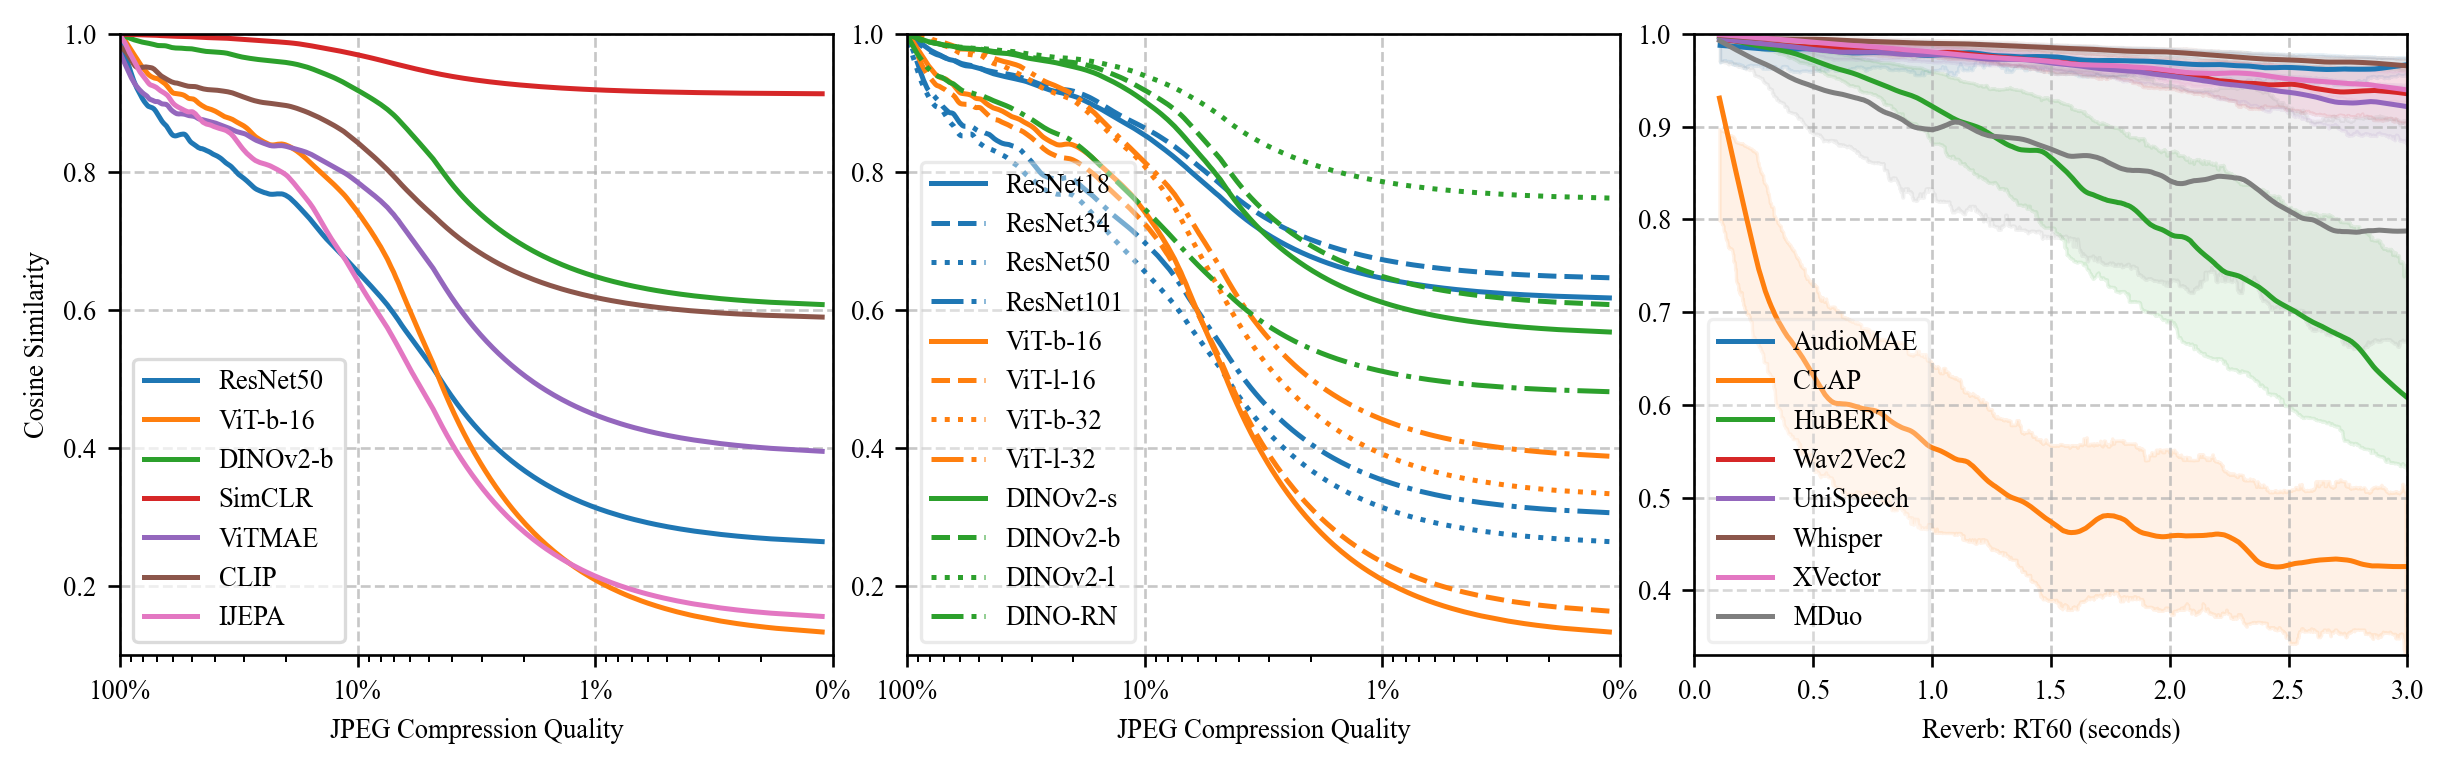

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- LibriSpeech Plotting ---
# List of features for which CSVs are available.
features_librispeech = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Container for each feature's dataframe.
dataframes_librispeech = {}

# Read each CSV into a dataframe:
for feature in features_librispeech:
    filename = f"../results/LibriSpeech_invariance/LibriSpeech_{feature}_AddReverb_feature_distances.csv"
    df = pd.read_csv(filename)
    dataframes_librispeech[feature] = df

# Assume each CSV has the same 'transform_param' values.
common_x_librispeech = dataframes_librispeech[features_librispeech[0]][
    "transform_param"
]

# Build a dataframe with cosine similarity columns for all features.
cosine_df_librispeech = pd.DataFrame(
    {
        feature: dataframes_librispeech[feature]["cosine_similarity"]
        for feature in features_librispeech
    }
)

# --- ImageNet Plotting ---
# List of features for which CSVs are available.
features_imagenet = [
    "ResNet50_ImageNet",
    "ViT_b_16_ImageNet",
    "DINOv2_base",
    "SimCLR",
    "ViT_MAE",
    "CLIP",
    "IJEPA",
]

# Container for each feature's dataframe.
dataframes_imagenet = {}

# Read each CSV into a dataframe:
for feature in features_imagenet:
    filename = f"../results/ImageNet_invariance/ImageNet_{feature}_JPEGCompression_feature_distances.csv"
    df = pd.read_csv(filename)
    dataframes_imagenet[feature] = df

# Assume each CSV has the same 'transform_param' values.
common_x_imagenet = dataframes_imagenet[features_imagenet[0]]["transform_param"]

# Build a dataframe with cosine similarity columns for all features.
cosine_df_imagenet = pd.DataFrame(
    {
        feature: dataframes_imagenet[feature]["cosine_similarity"]
        for feature in features_imagenet
    }
)

# --- ImageNet Ablation Plotting ---
# List of features_abl for which CSVs are available.
features_abl = [
    "ResNet18_ImageNet",
    "ResNet34_ImageNet",
    "ResNet50_ImageNet",
    "ResNet101_ImageNet",
    "ViT_b_16_ImageNet",
    "ViT_l_16_ImageNet",
    "ViT_b_32_ImageNet",
    "ViT_l_32_ImageNet",
    "DINOv2_small",
    "DINOv2_base",
    "DINOv2_large",
    "DINO_RN",
]

# Container for each feature's dataframe.
dataframes_abl = {}

# Read each CSV into a dataframe:
for feature in features_abl:
    filename = f"../results/ImageNet_invariance/ImageNet_{feature}_JPEGCompression_feature_distances.csv"
    df = pd.read_csv(filename)
    dataframes_abl[feature] = df

# Assume each CSV has the same 'transform_param' values.
common_x_abl = dataframes_abl[features_abl[0]]["transform_param"]

# Build a dataframe with cosine similarity columns for all features_abl.
cosine_df_abl = pd.DataFrame(
    {feature: dataframes_abl[feature]["cosine_similarity"] for feature in features_abl}
)

# --- Plotting Functions ---
plt.style.use(["default"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 8,
        "figure.dpi": 300,  # Set display DPI
        "savefig.dpi": 300,  # Set save DPI
    }
)


def calculate_smoothed_curve(x, y, frac=0.1):
    """Calculate smoothed curve using LOWESS."""
    # Sort data by x values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Apply LOWESS smoothing
    smoothed = lowess(y_sorted, x_sorted, frac=frac, it=1, return_sorted=False)

    return x_sorted, smoothed


def calculate_confidence_bands(x, y, window_size=0.1):
    """Calculate rolling quantiles for confidence bands."""
    df = pd.DataFrame({"x": x, "y": y})
    df = df.sort_values("x")

    # Calculate rolling quantiles
    rolling = df["y"].rolling(
        window=int(len(x) * window_size), center=True, min_periods=1
    )

    lower = rolling.quantile(0.25)
    upper = rolling.quantile(0.75)
    median = rolling.median()

    return df["x"], lower, median, upper


def clean_feature_name(feature):
    """Clean feature names by removing/replacing specific patterns."""
    return (
        feature.replace("_ImageNet", "")
        .replace("small", "s")
        .replace("base", "b")
        .replace("large", "l")
        .replace("ViT_MAE", "ViTMAE")
        .replace("_", "-")
    )


def create_librispeech_invariance_plot(
    dataframes, features, smoothing_frac=0.1, ax=None
):
    """Create static plot with linear x-axis for LibriSpeech."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for feature, color in zip(features, colors):
        x = dataframes[feature]["transform_param"].values
        y = dataframes[feature]["cosine_similarity"].values

        # Calculate confidence bands
        x_sorted, lower, median, upper = calculate_confidence_bands(x, y)

        # Calculate smoothed curve
        _, smoothed = calculate_smoothed_curve(x, y, frac=smoothing_frac)

        # Plot
        ax.fill_between(x_sorted, lower, upper, alpha=0.1, color=color)
        ax.plot(
            x_sorted,
            smoothed,
            label=feature,
            color=color,
            linewidth=1.5,
        )

    ax.set_xlabel("Reverb: RT60 (seconds)")
    # ax.set_ylabel("Cosine Similarity")
    # ax.set_title("Invariance: Reverb")
    ax.legend(loc="lower left", framealpha=0.3)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_ylim(0.33, 1.0)
    ax.set_xlim(0, 3)
    ax.margins(x=0, y=0)
    return fig, ax


def create_imagenet_invariance_plot(dataframes, features, smoothing_frac=0.1, ax=None):
    """Create static plot with logarithmic JPEG Quality (displayed as percentage) x-axis for ImageNet."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Clean feature names before plotting
    cleaned_features = [clean_feature_name(feat) for feat in features]

    for feature, clean_feat, color in zip(features, cleaned_features, colors):
        # Original transform parameter and cosine similarity
        x = dataframes[feature]["transform_param"].values
        y = dataframes[feature]["cosine_similarity"].values

        # Map transform parameter to JPEG Quality: quality=1 for no compression
        # quality=0.001 for full compression
        quality = 1 - 0.999 * x

        # Calculate confidence bands using the JPEG Quality values
        quality_sorted, lower, median, upper = calculate_confidence_bands(quality, y)

        # Calculate the smoothed curve using the JPEG Quality values
        quality_smoothed, smoothed = calculate_smoothed_curve(
            quality, y, frac=smoothing_frac
        )

        # Plot the confidence band and the smoothed curve
        ax.plot(quality_sorted, smoothed, label=clean_feat, color=color, linewidth=1.5)

    ax.set_xlabel("JPEG Compression Quality")
    ax.set_ylabel("Cosine Similarity")
    # ax.set_title("Invariance: JPEG Compression")
    ax.legend(loc="lower left", framealpha=0.7)  # Changed legend position
    ax.grid(True, linestyle="--", alpha=0.7)

    # Set logarithmic scale for the x-axis and reverse the direction
    ax.set_xscale("log")
    ax.set_xlim(1, 0.001)  # Reversed limits to show 100% on left
    ax.set_ylim(0.1, 1.0001)

    # Change x-axis tick labels to percentage (quality 1 => 100%)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.margins(x=0, y=0)
    return fig, ax


def create_imagenet_ablation_invariance_plot(
    dataframes_abl, features_abl, smoothing_frac=0.1, ax=None
):
    """Create static plot with logarithmic JPEG Quality (displayed as percentage) x-axis."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Define visual styles for each model family
    style_config = {
        "ResNet": {
            "color": "#1f77b4",  # Blue family
            "styles": [
                {"linestyle": "-", "alpha": 1.0, "linewidth": 2.5},  # ResNet18
                {"linestyle": "--", "alpha": 1.0, "linewidth": 2.5},  # ResNet34
                {"linestyle": ":", "alpha": 1.0, "linewidth": 3.0},  # ResNet50
                {"linestyle": "-.", "alpha": 1.0, "linewidth": 2.5},  # ResNet101
            ],
        },
        "ViT": {  # orange family
            "color": "#ff7f0e",
            "styles": [
                {"linestyle": "-", "alpha": 1.0, "linewidth": 2.5},  # ViT_b_16
                {"linestyle": "--", "alpha": 1.0, "linewidth": 2.5},  # ViT_l_16
                {"linestyle": ":", "alpha": 1.0, "linewidth": 3.0},  # ViT_b_32
                {"linestyle": "-.", "alpha": 1.0, "linewidth": 2.5},  # ViT_l_32
            ],
        },
        "DINOv2": {
            "color": "#2ca02c",  # Green family
            "styles": [
                {"linestyle": "-", "alpha": 1.0, "linewidth": 2.5},  # small
                {"linestyle": "--", "alpha": 1.0, "linewidth": 2.5},  # base
                {"linestyle": ":", "alpha": 1.0, "linewidth": 3.0},  # large
                {"linestyle": "-.", "alpha": 1.0, "linewidth": 2.5},  # DINO_RN
            ],
        },
    }

    # Group models by family
    model_groups = {
        "ResNet": [
            "ResNet18_ImageNet",
            "ResNet34_ImageNet",
            "ResNet50_ImageNet",
            "ResNet101_ImageNet",
        ],
        "ViT": [
            "ViT_b_16_ImageNet",
            "ViT_l_16_ImageNet",
            "ViT_b_32_ImageNet",
            "ViT_l_32_ImageNet",
        ],
        "DINOv2": ["DINOv2_small", "DINOv2_base", "DINOv2_large", "DINO_RN"],
    }

    # Plot each model family
    legend_elements = []

    for family, models in model_groups.items():
        style = style_config[family]

        for i, model in enumerate(models):
            if model in dataframes_abl:
                x = dataframes_abl[model]["transform_param"].values
                y = dataframes_abl[model]["cosine_similarity"].values

                # Map transform parameter to JPEG Quality
                quality = 1 - 0.999 * x

                # Calculate smoothed curve
                quality_smoothed, smoothed = calculate_smoothed_curve(
                    quality, y, frac=smoothing_frac
                )

                # Get display name
                display_name = clean_feature_name(model)

                # Plot with family-specific styling
                current_style = style["styles"][i % len(style["styles"])].copy()
                current_style["linewidth"] = (
                    1.5  # Reduced linewidth from 2.5/3.0 to 1.5
                )
                line = ax.plot(
                    quality_smoothed,
                    smoothed,
                    label=display_name,
                    color=style["color"],
                    **current_style,
                )
                legend_elements.append(line[0])

    # Customize the plot
    ax.set_xlabel("JPEG Compression Quality")
    # ax.set_ylabel("Cosine Similarity")
    # ax.set_title("Invariance: JPEG Compression")

    # Add legend
    ax.legend(
        handles=legend_elements,
        loc="lower left",
        framealpha=0.4,
        handlelength=2,
        ncol=1,  # Specify the number of columns in the legend
    )

    # Set axis properties
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_xscale("log")
    ax.set_xlim(1, 0.001)
    ax.set_ylim(0.1, 1.0001)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.margins(x=0, y=0)

    return fig, ax


# --- Main Plotting ---
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Create each plot
fig, ax1 = create_imagenet_invariance_plot(
    dataframes_imagenet, features_imagenet, ax=axes[0]
)
fig, ax2 = create_imagenet_ablation_invariance_plot(
    dataframes_abl, features_abl, ax=axes[1]
)
fig, ax3 = create_librispeech_invariance_plot(
    dataframes_librispeech, features_librispeech, ax=axes[2]
)

plt.tight_layout(pad=0)
plt.show()